In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Exercise 6.1

a. Show empirically that the information limit of 2 prediction bits per parameter also holds for nearest neighbors.

In [284]:
"""
For each individual function you generated, you count how many points you have to keep to still perfectly test on train.
I used all 16 function in of 2 variables, 32 functions of 4 dimensions, 64 of 8 dimensions. To get to the amount of points
you have to memorize, I average over all points I had to keep for this chosen dimensionality.

d=2: n_full=4, Avg. req. points for memorization n_avg=2.62, n_full/n_avg=1.5238095238095237
d=4: n_full=16, Avg. req. points for memorization n_avg=9.40, n_full/n_avg=1.702127659574468
d=8: n_full=256, Avg. req. points for memorization n_avg=131.60, n_full/n_avg=1.9452887537993921 # I actually got very close to this!!
"""

np.random.seed(0)

def get_avg_points(funcs, n_full):
    avg_mem_size = 0
    for function in funcs:
        for n_pts_to_train_on in range(1, n_full):
            indices = np.random.choice(range(n_full), n_pts_to_train_on, replace=False)
            X_train = function[indices, :-1]
            y_train = function[indices, -1]
            X_test = np.delete(function, indices, axis=0)[:, :-1]
            y_test = np.delete(function, indices, axis=0)[:, -1]
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy == 1.0:
                avg_mem_size += n_pts_to_train_on
                # break
    avg_mem_size /= len(funcs)
    return avg_mem_size

def run_experiment(dimensions=[2, 4, 8], n_classes=2):
    results = []
    for d in dimensions:
        n_full = 2 ** d
        function_limit = 2 ** 8 #d * 8 # Arbitrary limit to keep the number of functions reasonable
        # X = np.array([[int(x) for x in list(format(i, f'0{d}b'))] for i in range(n_full)]) # Generate all possible binary inputs of length d --> n_full = 2^d

        # X should be a random binary dataset of size n_full x d
        X = np.random.randint(0, 2, size=(n_full, d))

        # There are n_classes^n_full possible labelings. Since this number can be huge, we generate a random subset of size min(n_classes^n_full, function_limit)
        y = np.random.randint(0, n_classes, size=(n_classes ** n_full if n_classes ** n_full <= function_limit else function_limit, n_full))
        functions = [np.hstack((X, y[i].reshape(-1, 1))) for i in range(n_classes ** n_full if n_classes ** n_full <= function_limit else function_limit)] # Combine X with each possible labeling
        if 2 ** n_full > function_limit:
            print(f"d = {d}: Theoretical number of functions {n_classes ** n_full} was limited to function limit {function_limit}")
        else:
            print(f"d = {d}: Number of functions: {len(functions)}")
        n_avg = get_avg_points(functions, n_full)
        print(f"n/d = {n_full/d}")
        results.append({"d": d, "n_full": n_full, "n_functions": len(functions), "n_avg": n_avg, "n_full/n_avg": n_full/n_avg})
    return results

part_a = pd.DataFrame(run_experiment(dimensions=[1, 2, 3, 4], n_classes=2))
print(part_a.to_string(index=False))

d = 1: Number of functions: 4
n/d = 2.0
d = 2: Number of functions: 16
n/d = 2.0
d = 3: Number of functions: 256
n/d = 2.6666666666666665
d = 4: Number of functions: 65536
n/d = 4.0
 d  n_full  n_functions     n_avg  n_full/n_avg
 1       2            4  0.750000      2.666667
 2       4           16  1.062500      3.764706
 3       8          256  5.875000      1.361702
 4      16        65536 14.109161      1.134015


b. Extend your experiments to multi-class classification.

In [253]:
part_b = pd.DataFrame(run_experiment(n_classes=3))
print(part_b.to_string(index=False))

Number of functions: 81
Theoretical number of functions 43046721 was limited to function limit 256
Theoretical number of functions 139008452377144732764939786789661303114218850808529137991604824430036072629766435941001769154109609521811665540548899435521 was limited to function limit 256
 d  n_full  n_functions      n_avg  n_full/n_avg
 2       4           81   0.938272      4.263158
 4      16          256   6.347656      2.520615
 8     256          256 106.371094      2.406669


# Exercise 6.2

Implement a program that automatically creates a set of if-then clauses from the training table of a binary dataset of your choice. Implement different strategies to minimize the number of if-then clauses. Document your strategies, the number of resulting conditional clauses, and the accuracy achieved.

if (worst perimeter <= 105.95) and (worst concave points <= 0.135) and (area error <= 48.975) and (worst texture <= 30.145) then class: benign (proba: 100.0%) | based on 274 samples
if (worst perimeter > 105.95) and (worst perimeter > 117.45) and (fractal dimension error > 0.002) then class: malignant (proba: 100.0%) | based on 164 samples
if (worst perimeter <= 105.95) and (worst concave points <= 0.135) and (area error <= 48.975) and (worst texture > 30.145) and (worst texture > 30.265) and (worst smoothness <= 0.141) then class: benign (proba: 100.0%) | based on 33 samples
if (worst perimeter > 105.95) and (worst perimeter <= 117.45) and (worst smoothness > 0.136) and (worst texture > 17.53) then class: malignant (proba: 100.0%) | based on 22 samples
if (worst perimeter > 105.95) and (worst perimeter <= 117.45) and (worst smoothness <= 0.136) and (worst texture <= 25.67) then class: benign (proba: 100.0%) | based on 20 samples
if (worst perimeter <= 105.95) and (worst concave points

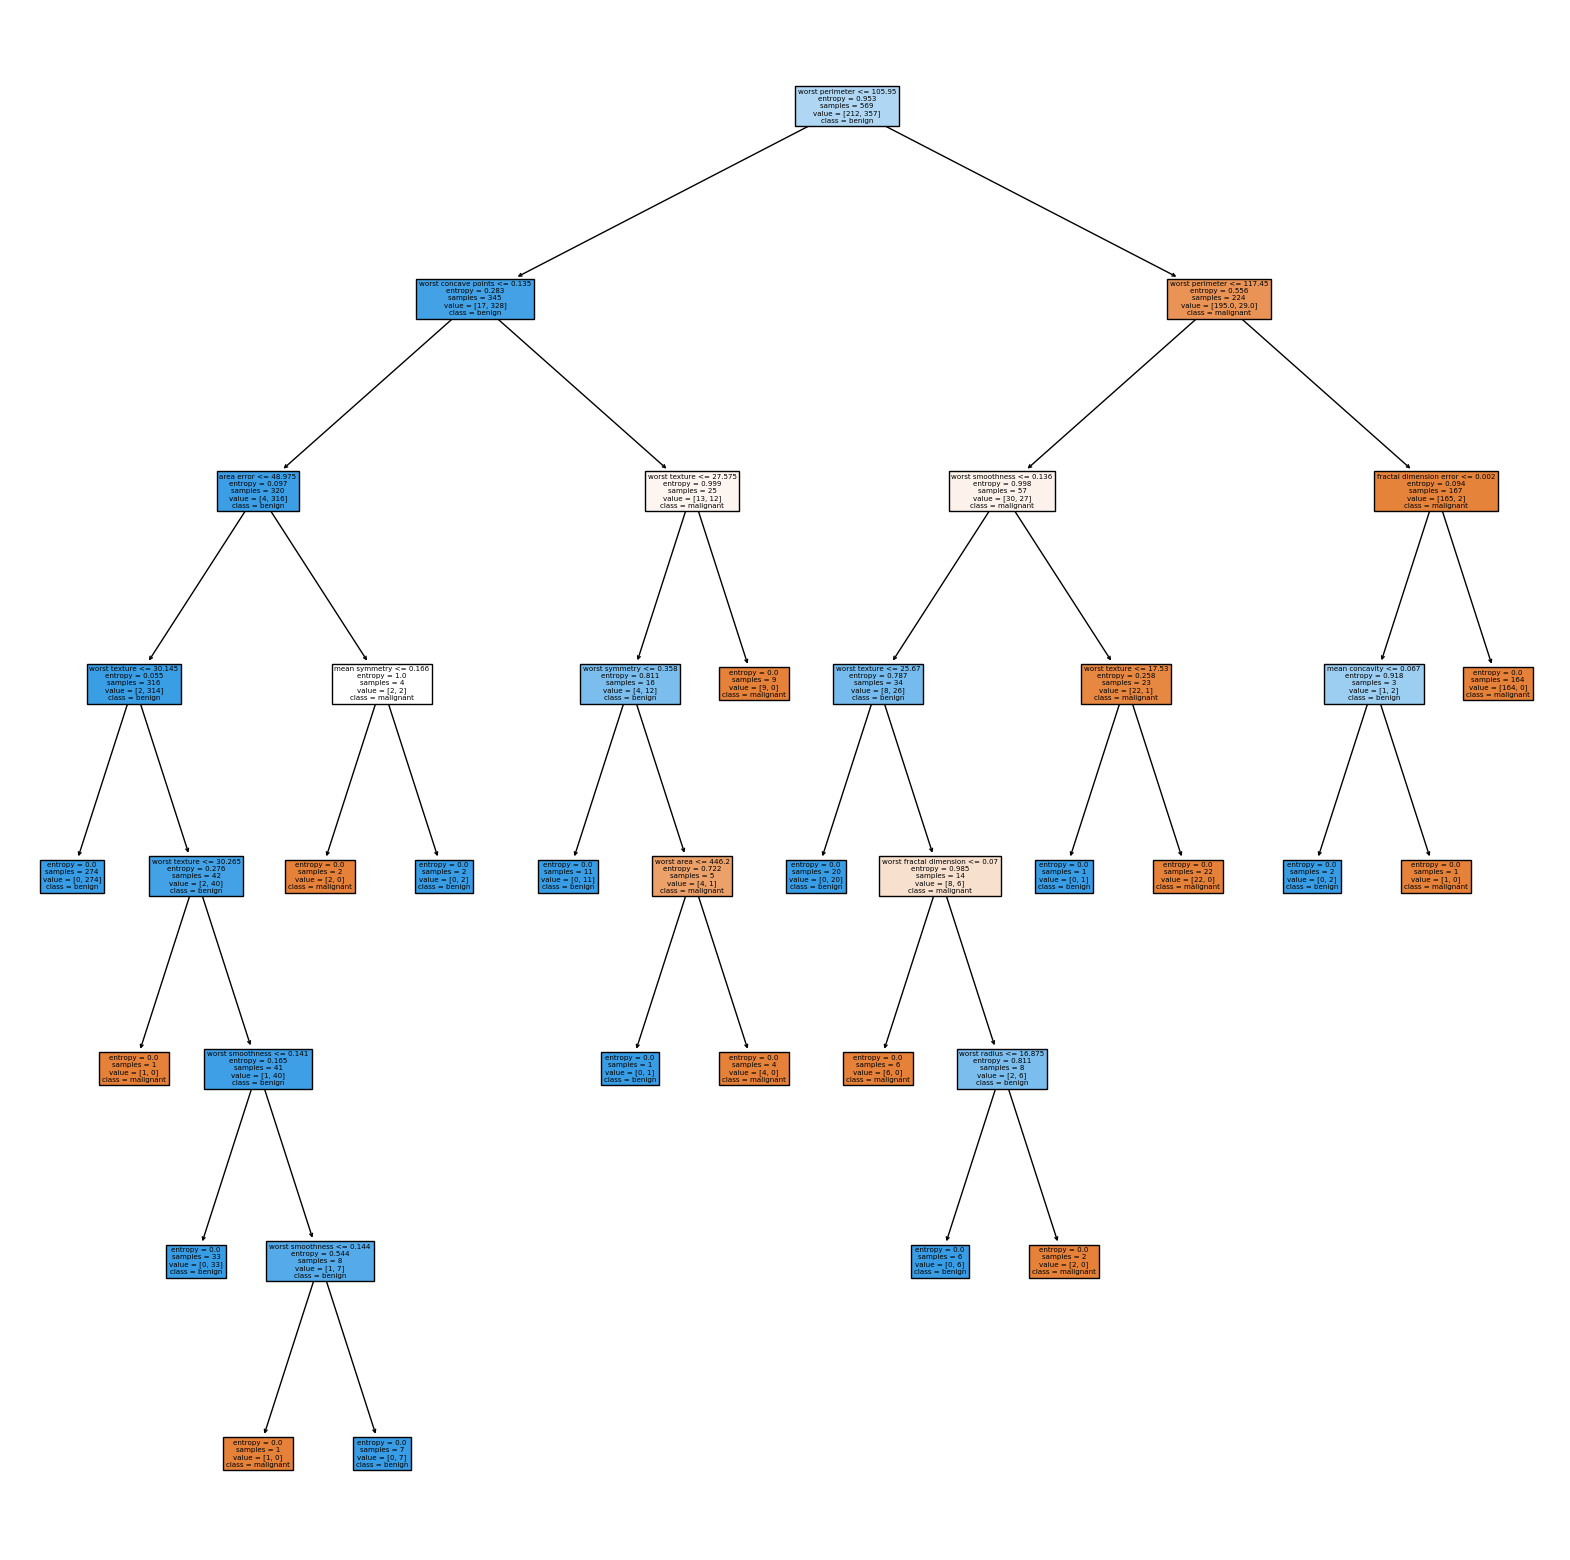

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

clf = DecisionTreeClassifier(random_state=0, criterion='entropy') # A decision tree is really just a bunch of if-then-else statements
clf.fit(X, y)

# Get the tree as a list of if-then clauses
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

rules = get_rules(clf, dataset.feature_names, dataset.target_names)

for r in rules:
    print(r)


# Get number of non-leaf nodes
n_nodes = clf.tree_.node_count
num_leaf_nodes = np.sum(clf.tree_.children_left == -1)
print(f"Number of nodes in the decision tree: {n_nodes}")
print(f"Number of non-leaf nodes (if-then clauses): {n_nodes - num_leaf_nodes}")

y_pred = clf.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred)}")

# Print decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 20))
plot_tree(clf, filled=True, feature_names=dataset.feature_names, class_names=dataset.target_names)
plt.show()

# Exercise 6.3

Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

In [14]:
# Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

import zlib
import sys

s = ''.join([str(np.random.randint(0, 2)) for _ in range(10000)])

compressed = zlib.compress(s.encode('utf-8'))
print(f"Original size: {sys.getsizeof(s)}")
print(f"Compression ratio: {sys.getsizeof(s) / sys.getsizeof(compressed)}")

## Use sys.getsizeof to get the size of the string in memory, not the length of the string

Original size: 10041
Compression ratio: 5.906470588235294


In [17]:
def entropy(s):
    _, counts = np.unique(list(s), return_counts=True) # Get the unique characters and their counts
    p = counts / len(s)
    return -np.sum(p * np.log2(p))

def ideal_entropy(n):
    p = 1 / 2
    return -n * p * np.log2(p)

print(f"Shannon entropy of the string: {entropy(s)}")
print(f"Entropy of a truly random string of the same length: {ideal_entropy(len(s))}")

Shannon entropy of the string: 0.9999992786523593
Entropy of a truly random string of the same length: 5000.0


What is the expected compression ratio? Explain why.

Assuming we have a truly random bit generator - which we don't, and cannot have - then the entropy of each bit is $log_2(0.5) = -1$. Since the bits are truly independent, we cannot compress the string, yielding a theoretical compression ratio of 1. However, in practice, we can compress the string, since the bit generation is not truly random. The lower the entropy of the string, the higher the compression ratio. Hence, we see a compression ratio of slightly more than 1. 